In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [2]:
data = pd.read_csv('../data/preprocessing_data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y
Теперь X обозначает обучающую выборку, y - ответы на ней

In [4]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

In [5]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [8]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Пропущенные значения можно интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется)

1. Заполним пропущенные вещественные значения в X нулями и средними по столбцам b назовем полученные датафреймы X_real_zeros и X_real_mean соответственно.
2. Все категориальные признаки в X преобразуем в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями (например, 'NA'), полученный датафрейм назовем X_cat.

In [9]:
X_real_zeros = X[numeric_cols].fillna(0)
X_real_mean = X[numeric_cols].fillna(X.mean(axis=0))
X_cat = X[categorical_cols].fillna('NA', axis=0).applymap(str)

В предыдущей ячейке мы разделили наш датасет ещё на две части: в одной присутствуют только вещественные признаки, в другой только категориальные. Это понадобится нам для раздельной последующей обработке этих данных, а так же для сравнения качества работы тех или иных методов.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Для этого используем преоборазования категориальных признаков в вещественные с помощью алгоритма one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

In [10]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

In [11]:
from sklearn.cross_validation import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Итак, мы получили первые наборы данных, для которых выполнены оба ограничения логистической регрессии на входные данные. Обучим на них регрессию, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, log_loss

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
def write_answer_1(auc_1, auc_2):
    auc = (auc_1 + auc_2)/2
    with open("preprocessing_lr_answer1.txt", "w") as fout:
        fout.write(str(auc))
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

# place your code here

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


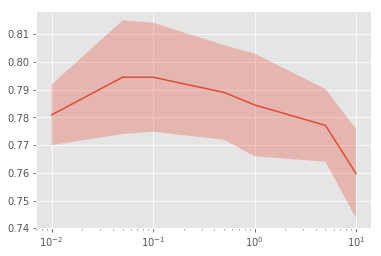

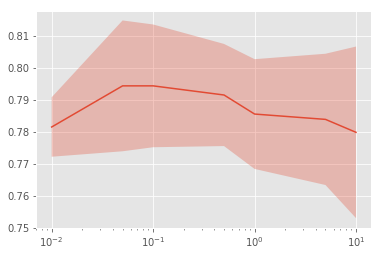

0.884910740691 0.884106435555
0.434615758133 0.435912080351


In [13]:
learn_zeros = np.hstack((X_train_real_zeros, X_train_cat_oh))
learn_means = np.hstack((X_train_real_mean, X_train_cat_oh))

classifier = LogisticRegression(random_state = 0)

grid_cv_zeros = GridSearchCV(classifier, param_grid, cv=cv)
grid_cv_means = GridSearchCV(classifier, param_grid, cv=cv)
grid_cv_zeros.fit(learn_zeros, y_train)
grid_cv_means.fit(learn_means, y_train)

test_zeros = np.hstack((X_test_real_zeros, X_test_cat_oh))
test_means = np.hstack((X_test_real_mean, X_test_cat_oh))

predicted_zeros=grid_cv_zeros.best_estimator_.predict_proba(test_zeros)[:, 1]
predicted_means=grid_cv_means.best_estimator_.predict_proba(test_means)[:, 1]

plot_scores(grid_cv_zeros)
plot_scores(grid_cv_means)

roc_zeros = roc_auc_score(y_test, predicted_zeros)
roc_means = roc_auc_score(y_test, predicted_means)

log_zeros = log_loss(y_test, predicted_zeros)
log_means = log_loss(y_test, predicted_means)


print (roc_means, roc_zeros)
print (log_means, log_zeros)
write_answer_1(roc_means, roc_zeros)

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


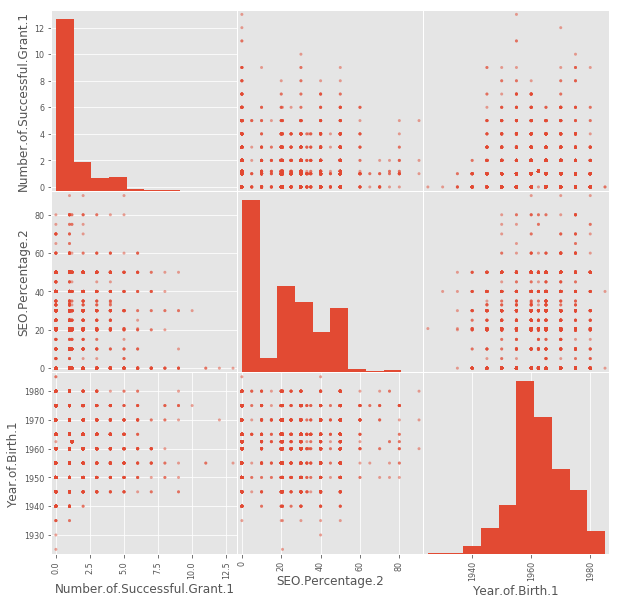

In [14]:
from pandas.tools.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_mean, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_real_mean)
X_train_real_scaled = scaler.transform(X_train_real_mean)
X_test_real_scaled = scaler.transform(X_test_real_mean)

1. Обучим ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Проверим, был ли найден оптимум accuracy по гиперпараметрам во время кроссвалидации.
3. Получим значение ROC AUC на тестовой выборке, сравните с лучшим результатом, полученными ранее.
4. Запишем полученный ответ в файл при помощи функции write_answer_2.

In [17]:
def write_answer_2(auc):
    with open("preprocessing_lr_answer2.txt", "w") as fout:
        fout.write(str(auc))
        
learn_means_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
grid_cv_means_scaled = GridSearchCV(classifier, param_grid, cv = 3)
grid_cv_means_scaled.fit(learn_means_scaled, y_train)

test_means_scaled=np.hstack((X_test_real_scaled, X_test_cat_oh))
predicted_means_scaled = grid_cv_means_scaled.best_estimator_.predict_proba(test_means_scaled)[:, 1]

auc = roc_auc_score(y_test, predicted_means_scaled)
write_answer_2(auc)

1. Обучим логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках.
2. Получим метрику ROC AUC на тестовой выборке.
3. Сбалансируем выборку, досэмплировав в неё объекты из меньшего класса. 
4. Получим метрику ROC AUC на тестовой выборке, и сравним с предыдущим результатом.
5. Внесем ответы в выходной файл при помощи функции write_asnwer_3, передав в неё сначала ROC AUC для балансировки весами, а потом балансировки выборки вручную.

In [18]:
def write_answer_3(auc_1, auc_2):
    auc = (auc_1 + auc_2) / 2
    with open("preprocessing_lr_answer3.txt", "w") as fout:
        fout.write(str(auc))
        
classifier = LogisticRegression(random_state = 0, class_weight='balanced')
grid_cv_means_scaled_bal = GridSearchCV(classifier, param_grid, cv = 3)
grid_cv_means_scaled_bal.fit(learn_means_scaled, y_train)
predicted_means_scaled_bal = grid_cv_means_scaled_bal.best_estimator_.predict_proba(test_means_scaled)[:, 1]
roc_means_scaled_bal = roc_auc_score(y_test, predicted_means_scaled_bal)
log_loss_scaled_bal= log_loss(y_test, predicted_means_scaled_bal)

np.random.seed(0)

indices_to_add = np.random.randint(np.sum(y_train==1), size=(np.sum(y_train==0) - np.sum(y_train==1)))
X_train_to_add = X_train_real_scaled[y_train.as_matrix() == 1,:][indices_to_add,:]
X_train_real_scaled_samp = np.vstack((X_train_real_scaled, X_train_to_add))

y_train_to_add = y_train[y_train == 1][indices_to_add]
y_train_to_add = y_train_to_add.fillna(1)
y_train_samp = np.hstack((y_train, y_train_to_add))

X_train_cat_oh_add = X_train_cat_oh[y_train.as_matrix() == 1,:][indices_to_add,:]
X_train_cat_oh_samp = np.vstack((X_train_cat_oh, X_train_cat_oh_add))

classifier = LogisticRegression(random_state = 0)
grid_cv_means_scaled_samp = GridSearchCV(classifier, param_grid, cv = 3)
learn_means_scaled_samp = np.hstack((X_train_real_scaled_samp,X_train_cat_oh_samp))
grid_cv_means_scaled_samp.fit(learn_means_scaled_samp, y_train_samp)
predicted_means_scaled_samp = grid_cv_means_scaled_samp.best_estimator_.predict_proba(test_means_scaled)[:, 1]
roc_means_scaled_samp = roc_auc_score(y_test, predicted_means_scaled_samp)
log_loss_scaled_samp = log_loss(y_test, predicted_means_scaled_samp)

print(roc_means_scaled_bal, roc_means_scaled_samp)
print(log_loss_scaled_bal, log_loss_scaled_samp)
write_answer_3(roc_means_scaled_bal, roc_means_scaled_samp)


0.888030207226 0.884435581964
0.428378692204 0.440515884306


Проведем сттратификацию выборок

In [19]:
def write_answer_4(auc):
    with open("preprocessing_lr_answer4.txt", "w") as fout:
        fout.write(str(auc))
        

(X_train_real_mean, X_test_real_mean, X_train_cat_oh, X_test_cat_oh, y_train, y_test) = train_test_split(X_real_mean, X_cat_oh, y, test_size=0.3, random_state=0, stratify=y)


scaler = StandardScaler()
scaler.fit(X_train_real_mean)
X_train_real_scaled = scaler.transform(X_train_real_mean)
X_test_real_scaled = scaler.transform(X_test_real_mean)

learn_means_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
test_means_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

classifier = LogisticRegression(random_state = 0, class_weight='balanced')
grid_cv_means_scaled_bal = GridSearchCV(classifier, param_grid, cv = 3)
grid_cv_means_scaled_bal.fit(learn_means_scaled, y_train)
predicted_means_scaled_bal = grid_cv_means_scaled_bal.best_estimator_.predict_proba(test_means_scaled)[:, 1]
roc_means_scaled_bal = roc_auc_score(y_test, predicted_means_scaled_bal)
log_loss_scaled_bal= log_loss(y_test, predicted_means_scaled_bal)

print(roc_means_scaled_bal)
print(log_loss_scaled_bal)
write_answer_4(roc_means_scaled_bal)




0.876918110847
0.443570843548


Теперь рассмотрим способы преобразования признаков. Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самым базовым является полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков вы дополнительно включаете набор все полиномы степени p, которые можно из них построить. 

1. Реализуем преобразование вещественных признаков модели при помощи полиномиальных признаков степени 2
2. Построим логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. 
3. Получим AUC ROC на тесте и сравним данный результат с использованием обычных признаков.
4. Передадим полученный ответ в функцию write_answer_5.

In [21]:
from sklearn.preprocessing import PolynomialFeatures
def write_answer_5(auc):
    with open("preprocessing_lr_answer5.txt", "w") as fout:
        fout.write(str(auc))
        
transform = PolynomialFeatures(2)
X_train_real_mean_poly = transform.fit_transform(X_train_real_mean)
X_test_real_mean_poly = transform.fit_transform(X_test_real_mean)

scaler = StandardScaler()
scaler.fit(X_train_real_mean_poly)
X_train_real_poly_scaled = scaler.transform(X_train_real_mean_poly)
X_test_real_poly_scaled = scaler.transform(X_test_real_mean_poly)

learn_means_scaled = np.hstack((X_train_real_poly_scaled, X_train_cat_oh))
test_means_scaled = np.hstack((X_test_real_poly_scaled, X_test_cat_oh))

classifier = LogisticRegression(random_state = 0, class_weight='balanced', fit_intercept=False)
grid_cv_means_scaled_bal = GridSearchCV(classifier, param_grid, cv = 3)
grid_cv_means_scaled_bal.fit(learn_means_scaled, y_train)
predicted_means_scaled_bal = grid_cv_means_scaled_bal.best_estimator_.predict_proba(test_means_scaled)[:, 1]
roc_means_scaled_bal = roc_auc_score(y_test, predicted_means_scaled_bal)
log_loss_scaled_bal= log_loss(y_test, predicted_means_scaled_bal)

print(roc_means_scaled_bal)
print(log_loss_scaled_bal)
write_answer_5(roc_means_scaled_bal)


0.885665293389
0.435398523614


К логистической регрессии также можно применить L1-регуляризацию (Lasso), вместо регуляризации L2, которая будет приводить к отбору признаков. 

1. Обучим регрессию Lasso на стратифицированных отмасштабированных выборках, используя балансировку классов при помощи весов.
2. Получитим ROC AUC регрессии и сравним его с предыдущими результатами.
3. Найдем номера вещественных признаков, которые имеют нулевые веса в итоговой модели.
4. Передадим их список функции write_answer_6.

In [22]:
def write_answer_6(features):
    with open("preprocessing_lr_answer6.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in features]))
        
scaler = StandardScaler()
scaler.fit(X_train_real_mean)
X_train_real_scaled = scaler.transform(X_train_real_mean)
X_test_real_scaled = scaler.transform(X_test_real_mean)

learn_means_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
test_means_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

classifier = LogisticRegression(random_state = 0, class_weight='balanced', penalty='l1')
grid_cv_means_scaled_bal = GridSearchCV(classifier, param_grid, cv = 3)
grid_cv_means_scaled_bal.fit(learn_means_scaled, y_train)
predicted_means_scaled_bal = grid_cv_means_scaled_bal.best_estimator_.predict_proba(test_means_scaled)[:, 1]
roc_means_scaled_bal = roc_auc_score(y_test, predicted_means_scaled_bal)
log_loss_scaled_bal= log_loss(y_test, predicted_means_scaled_bal)

print(roc_means_scaled_bal)
print(log_loss_scaled_bal)

columns = X_real_mean.columns
coefs = grid_cv_means_scaled_bal.best_estimator_.coef_[0][:len(columns)]


0.878138387593
0.444983170361
